In [17]:
from pathlib import Path
import numpy as np
from mmml.transformations.dscribe_helpers import *
import ase
from ase.visualize import plot as plot_ase

data_path = Path("/home/ericb/beta-diketones_71208.npz")
data = np.load(data_path)
keys = list(data.keys())
n_data = len(data[keys[0]])
n_div = 10
n_atoms_max = 17
all_ase_atoms = LazyAtomsLoader(data)
n_data

71208

In [18]:
ase.visualize.view(all_ase_atoms[3571], viewer="x3d")

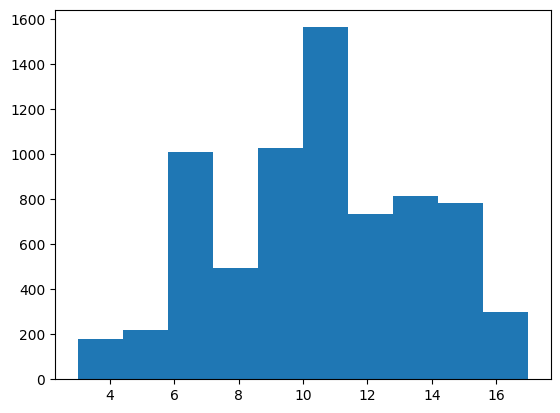

In [19]:
_ = plt.hist(data["N"][::n_div])

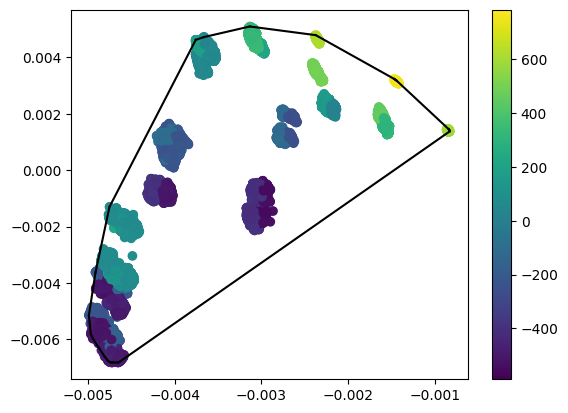

In [25]:
from dscribe.descriptors import CoulombMatrix
from mmml.transformations.pca import fit as fit_pca
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt


do_title = False
do_annotate = False

cm = CoulombMatrix(n_atoms_max=n_atoms_max)

coulomb_matrices = cm.create(all_ase_atoms, n_jobs=4,)  # Parallel

coulomb_matrices = np.nan_to_num(coulomb_matrices)

coulomb_matrices_2d_PCA = fit_pca(coulomb_matrices.T, 2)
coulomb_matrices_2d_X = coulomb_matrices_2d_PCA.components.T
coulomb_matrices_2d_X.shape

ax = plt.gca()

hull = ConvexHull(coulomb_matrices_2d_X)

s = plt.scatter(coulomb_matrices_2d_X[:,0], coulomb_matrices_2d_X[:,1], c=(data["E"] - data["E"].mean())*23)
for simplex in hull.simplices:
    ax.plot(coulomb_matrices_2d_X[simplex, 0], coulomb_matrices_2d_X[simplex, 1], 'k-')

if do_annotate:
    # Hull vertices
    verts = ConvexHull(coulomb_matrices_2d_X).vertices
    idx_map = {v: v for v in verts}
    
    # Centers of insets = hull vertex coordinates
    centers = coulomb_matrices_2d_X[verts, :2]
    
    # Non-overlapping inset rectangles
    rects = adjust_inset_positions(ax, centers, box_wh=(0.00152, 0.00152), pad=0.0005)
    
    # Draw the insets + lines
    for (v, rect, center) in zip(verts, rects, centers):
        x, y, w, h = rect
        inset_center = np.array([x + w/2, y + h/2])
    
        # draw leader line from structure point to inset center
        ax.plot([center[0], inset_center[0]],
                [center[1], inset_center[1]], 'k-', lw=0.6)
    
        # inset itself
        inset = ax.inset_axes([x, y, w, h], transform=ax.transData)
        if do_title:
            inset.set_title(f"{v}")
        plot_ase.plot_atoms(all_ase_atoms[idx_map[v]], ax=inset)
        inset.set_axis_off()

plt.colorbar(s)
plt.show()